### 安装包

In [35]:
!pip install xgboost

### Package Import

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

### 数据读取

In [37]:
# 读取数据
df = pd.read_csv('/Users/allen/Desktop/wms415-530发货回传商品明细/卡牌发货.csv', encoding='GBK')
df['日期'] = pd.to_datetime(df['日期'])

# 按日期分组并求和
df_grouped = df.groupby('日期')['wms实际发货数量'].sum().reset_index()
df_grouped = df_grouped.sort_values(by='日期')
df_grouped.set_index('日期', inplace=True)

print(f"数据总长度: {len(df_grouped)}")

数据总长度: 45


### 数据类型趋势观察

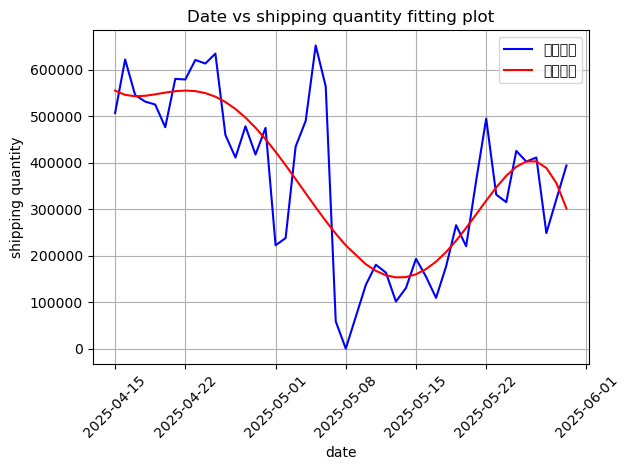

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# 读取数据
df = pd.read_csv('/Users/allen/Desktop/wms415-530发货回传商品明细/卡牌发货.csv', encoding='GBK')

# 将 '日期' 列转换为日期格式
df['日期'] = pd.to_datetime(df['日期'])

# 按 '日期' 分组并求和 'wms实际发货数量'
df_grouped = df.groupby('日期')['wms实际发货数量'].sum().reset_index()

# 按日期排序
df_grouped = df_grouped.sort_values(by='日期')

# 将日期转换为数字
df_grouped['日期_numeric'] = (df_grouped['日期'] - df_grouped['日期'].min()).dt.days

# 数据拟合（多项式拟合）
X = df_grouped['日期_numeric'].values.reshape(-1, 1)
y = df_grouped['wms实际发货数量'].values

poly = PolynomialFeatures(degree=5)  # 使用5次多项式拟合
X_poly = poly.fit_transform(X)

# 拟合数据
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_poly, y)

# 预测拟合曲线
y_pred = model.predict(X_poly)

# 可视化拟合曲线
plt.plot(df_grouped['日期'], y, label='原始数据', color='blue')
plt.plot(df_grouped['日期'], y_pred, label='拟合曲线', color='red')
plt.title('Date vs shipping quantity fitting plot')
plt.xlabel('date')
plt.ylabel('shipping quantity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


数据趋势非线性，且数据量较少，可采取时间序列ARIMA模型

## SARIMA模型（季节性7天）

训练集长度: 15
测试集长度: 30
ADF统计量: -4.900169146341824, p值: 3.484793099581514e-05 → d=0


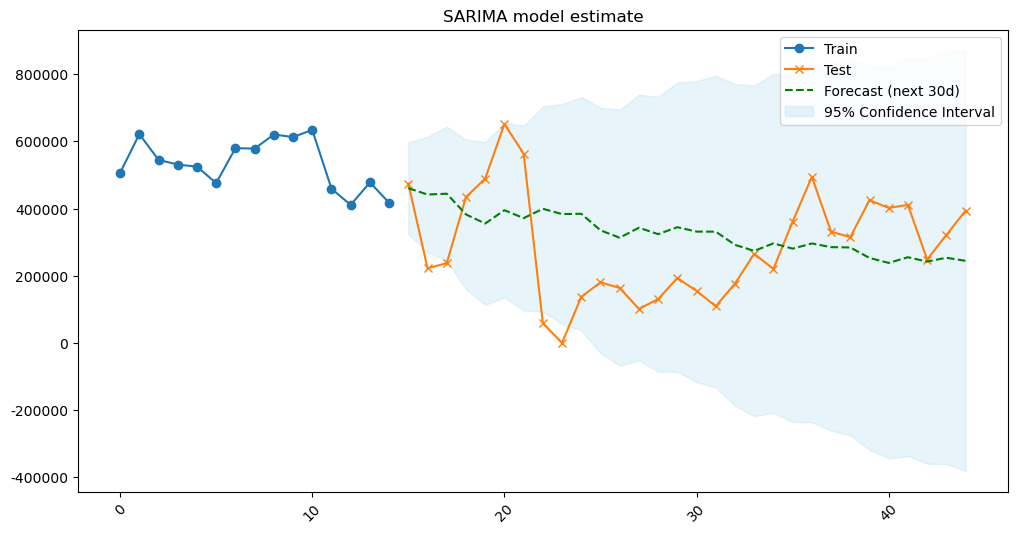


===== 原始数据预测（30天） =====
预测日期	 预测数量
2025-05-31	460707.00
2025-06-01	441924.75
2025-06-02	444341.39
2025-06-03	382546.22
2025-06-04	355539.69
2025-06-05	395080.25
2025-06-06	371552.22
2025-06-07	399397.38
2025-06-08	383666.70
2025-06-09	384509.08
2025-06-10	335266.88
2025-06-11	313202.02
2025-06-12	343098.96
2025-06-13	323801.30
2025-06-14	344621.89
2025-06-15	331459.19
2025-06-16	331254.41
2025-06-17	291985.44
2025-06-18	273949.00
2025-06-19	296486.96
2025-06-20	280653.48
2025-06-21	296150.20
2025-06-22	285145.66
2025-06-23	284273.54
2025-06-24	252933.82
2025-06-25	238183.21
2025-06-26	255116.14
2025-06-27	242120.59
2025-06-28	253593.19
2025-06-29	244400.20


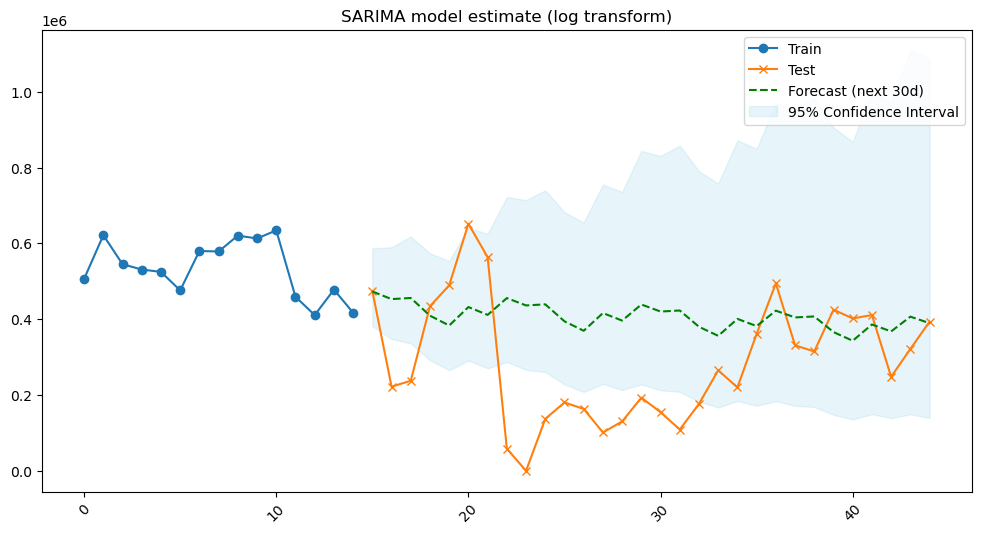


===== log变换预测（30天） =====
预测日期	 预测数量
2025-05-31	473221.90
2025-06-01	453028.32
2025-06-02	456077.14
2025-06-03	409332.76
2025-06-04	383406.96
2025-06-05	432120.03
2025-06-06	411451.39
2025-06-07	455742.32
2025-06-08	436367.87
2025-06-09	439270.41
2025-06-10	394439.09
2025-06-11	369558.09
2025-06-12	416249.80
2025-06-13	396417.39
2025-06-14	438851.25
2025-06-15	420265.30
2025-06-16	423028.22
2025-06-17	380037.41
2025-06-18	356162.37
2025-06-19	400910.88
2025-06-20	381883.47
2025-06-21	422533.06
2025-06-22	404705.91
2025-06-23	407335.61
2025-06-24	366115.07
2025-06-25	343208.37
2025-06-26	386089.26
2025-06-27	367836.56
2025-06-28	406772.25
2025-06-29	389675.13


In [39]:
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# 拆分训练/测试
test_size = 30
if len(df_grouped) > test_size:
    train_data = df_grouped.iloc[:-test_size]
    test_data = df_grouped.iloc[-test_size:]
else:
    train_data = df_grouped
    test_data = None

print(f"训练集长度: {len(train_data)}")
if test_data is not None:
    print(f"测试集长度: {len(test_data)}")

# ADF检验
result = adfuller(train_data['wms实际发货数量'])
d = 0 if result[1] <= 0.05 else 1
print(f"ADF统计量: {result[0]}, p值: {result[1]} → d={d}")


# =============== 模型1：原始数据建模 ===============
model_arima_raw = SARIMAX(
    train_data['wms实际发货数量'], 
    order=(1, d, 1), 
    seasonal_order=(1, 0, 1, 7),
    trend='n'
)  
fit_arima_raw = model_arima_raw.fit(disp=False)

forecast_raw = fit_arima_raw.get_forecast(steps=30)
forecast_raw_mean = forecast_raw.predicted_mean
forecast_raw_ci = forecast_raw.conf_int()

# 绘制 原始数据建模
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['wms实际发货数量'], label='Train', marker='o')
if test_data is not None:
    plt.plot(test_data.index, test_data['wms实际发货数量'], label='Test', marker='x')
plt.plot(forecast_raw_mean.index, forecast_raw_mean, label='Forecast (next 30d)', linestyle='--', color='green')
plt.fill_between(forecast_raw_ci.index, forecast_raw_ci.iloc[:,0], forecast_raw_ci.iloc[:,1], 
                 alpha=0.2, color='skyblue', label='95% Confidence Interval')
plt.title('SARIMA model estimate')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 打印 原始预测结果
print("\n===== 原始数据预测（30天） =====")
last_date = df_grouped['日期'].iloc[-1] 
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
print("预测日期\t 预测数量")
for date, value in zip(forecast_dates, forecast_raw_mean):
    print(f"{date.strftime('%Y-%m-%d')}\t{value:.2f}")


# =============== 模型2：对数变换建模 ===============
train_log = np.log1p(train_data['wms实际发货数量'])

model_arima_log = SARIMAX(
    train_log, 
    order=(1, d, 1), 
    seasonal_order=(1, 0, 1, 7),
    trend='n'
)  
fit_arima_log = model_arima_log.fit(disp=False)

forecast_log = fit_arima_log.get_forecast(steps=30)
forecast_log_mean = forecast_log.predicted_mean
forecast_log_ci = forecast_log.conf_int()

# 还原
forecast_log_mean = np.expm1(forecast_log_mean)
forecast_log_ci = np.expm1(forecast_log_ci)

# 绘制 对数变换建模
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['wms实际发货数量'], label='Train', marker='o')
if test_data is not None:
    plt.plot(test_data.index, test_data['wms实际发货数量'], label='Test', marker='x')
plt.plot(forecast_log_mean.index, forecast_log_mean, label='Forecast (next 30d)', linestyle='--', color='green')
plt.fill_between(forecast_log_ci.index, forecast_log_ci.iloc[:,0], forecast_log_ci.iloc[:,1], 
                 alpha=0.2, color='skyblue', label='95% Confidence Interval')
plt.title('SARIMA model estimate (log transform)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 打印 log预测结果
print("\n===== log变换预测（30天） =====")
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
print("预测日期\t 预测数量")
for date, value in zip(forecast_dates, forecast_log_mean):
    print(f"{date.strftime('%Y-%m-%d')}\t{value:.2f}")


目前数据量较少，时间序列模型表现更好一点，等数据量加大，可采取XGBOOST模型

## XGBOOST模型预测

In [ ]:
# 构造滑动窗口数据
values = df_grouped['wms实际发货数量'].values
window_in = 15
window_out = 30

X, Y = [], []
for i in range(len(values) - window_in - window_out + 1):
    X.append(values[i:i+window_in])
    Y.append(values[i+window_in:i+window_in+window_out])
X, Y = np.array(X), np.array(Y)

# 拆成训练集/测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# 训练模型（逐天预测未来30天）
models = []
for step in range(window_out):
    y_step = Y_train[:, step]   # 第 step 天的目标
    model = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05)
    model.fit(X_train, y_step)
    models.append(model)

# 用最后15天预测未来30天
last_input = values[-window_in:]
preds = []
cur_input = last_input.copy()

for step in range(window_out):
    pred = models[step].predict(cur_input.reshape(1, -1))[0]
    preds.append(pred)
    # 可以决定是否更新输入（滚动预测）
    cur_input = np.append(cur_input[1:], pred)

# 打印预测结果
future_dates = pd.date_range(start=df_grouped['日期'].max() + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({'日期': future_dates, '预测发货量': np.array(preds, dtype=int)})
print(future_df)


## LSTM模型预测

In [ ]:
# 数据准备
values = df_grouped['wms实际发货数量'].values.reshape(-1, 1)

# 归一化（LSTM 训练更稳定）
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

window_in = 15
window_out = 30

X, Y = [], []
for i in range(len(scaled) - window_in - window_out + 1):
    X.append(scaled[i:i+window_in, 0])
    Y.append(scaled[i+window_in:i+window_in+window_out, 0])
X, Y = np.array(X), np.array(Y)

# LSTM 需要 [样本数, 时间步, 特征数]
X = X.reshape((X.shape[0], X.shape[1], 1))

# 搭建模型
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(window_in, 1)))
model.add(Dense(window_out))  # 直接预测30天
model.compile(optimizer='adam', loss='mse')

# 训练
model.fit(X, Y, epochs=50, batch_size=16, verbose=1)

# 用最后一个窗口预测未来30天
last_input = scaled[-window_in:].reshape(1, window_in, 1)
pred_scaled = model.predict(last_input)
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

# 打印预测结果
future_dates = pd.date_range(start=df_grouped['日期'].max() + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({'日期': future_dates, '预测发货量': pred.astype(int)})
print(future_df)
